In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.transform.radon_transform import _get_fourier_filter
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift, fft2, ifft2
from skimage.data import shepp_logan_phantom

> **_NOTE:_** code below is from the examples.

In [23]:
def rad2cart(data, r, theta, x, y):
    """
    Bi-linear interpolation from radial grid (r,theta) to cartesian grid (x,y).
    Polar coordinates are represented with r > 0 and theta \in [0,2*pi).
    All grids are assumed to be regularly spaced.
    
    Input: 
        data     - 2d array of size (nr,ntheta) containing values on the radial grid
        r, theta - 1d arrays of size nr and ntheta containing the polar gridpoints
        x,y      - 1d arrays of size nx and ny containing the cartesian gridpoints
        
    Output:
        result   - 2d array of size (nx,ny) containing the interpolated values
    """

    # get some grid related quantities (assumes regularly spaced grids)
    nr = len(r)
    dr = r[1] - r[0]
    nt = len(theta)
    dt = theta[1] - theta[0]    
    nx = len(x)
    dx = x[1] - x[0]
    ny = len(y)
    dy = y[1] - y[0]
    
    
    # initialise result
    result = np.zeros((nx, ny), dtype=type(data[0, 0]))
    
    # loop over output grid
    for i in range(nx):
        for j in range(ny):
            # polar coordinates of current point (x[i], y[j])
            theta_ij = np.arctan2(x[i], y[j]) + np.pi # to map from [-pi,pi) to [0,2*pi)
            r_ij     = np.sqrt(x[i]**2 + y[j]**2)
            
            # look for lower-left gridpoint
            k = int((r_ij - r[0]) // dr)
            l = int((theta_ij - theta[0]) // dt)
            
            # check if i,j is an internal grid point and apply interpolation formula, 
            # see e.g., https://en.wikipedia.org/wiki/Bilinear_interpolation
            if (0 <= k < nr-1) and (0 <= l < nt-1):
                A = (r[k+1] - r_ij) * (theta[l+1] - theta_ij) / (dr * dt)
                B = (r_ij - r[k  ]) * (theta[l+1] - theta_ij) / (dr * dt)
                C = (r[k+1] - r_ij) * (theta_ij - theta[l  ]) / (dr * dt)
                D = (r_ij - r[k  ]) * (theta_ij - theta[l  ]) / (dr * dt)
                
                result[i,j] = A*data[k, l] + B*data[k+1, l] + C*data[k, l+1] + D*data[k+1, l+1]
    return result 

> **_NOTE:_** code below is from the examples.

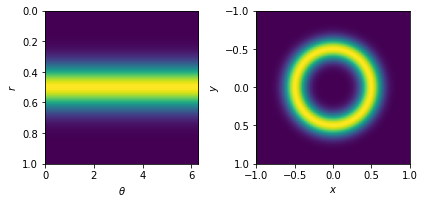

In [70]:
# We can check the interpolation code by generating a function in polar coordinates and mapping it to cartesian coordinates
nr = 100
nt = 100

# radial grid
r     = np.linspace(0,1 ,nr)
theta = np.linspace(0, 2*np.pi, nt)

# cartesian grid
x = np.linspace(-1, 1, nr)
y = np.linspace(-1, 1, nr)

# function in polar coordinates
tt,rr = np.meshgrid(theta, r)
g_polar = np.exp(-50*(rr-.5)**2)

# interpolate
g_cart = rad2cart(g_polar, r, theta, x, y)

fig,ax = plt.subplots(1, 2)
ax[0].imshow(g_polar, extent=(theta[0], theta[-1], r[-1], r[0]))
ax[0].set_xlabel(r"$\theta$")
ax[0].set_ylabel(r"$r$")
ax[0].set_aspect((theta[-1]-theta[0])/(r[-1]-r[0]))

ax[1].imshow(g_cart, extent=(x[0],x[-1],y[-1],y[0]))
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$y$")
ax[1].set_aspect((x[-1]-x[0])/(y[-1]-y[0]))

fig.tight_layout()
fig.set_figwidth(6)
fig.set_figheight(2.5)

plt.savefig("./figures/lec2/cart_to_polar.png", 
            dpi=300, transparent = True, bbox_inches = "tight", pad_inches = 0)

> **_NOTE:_** code below is from the examples.

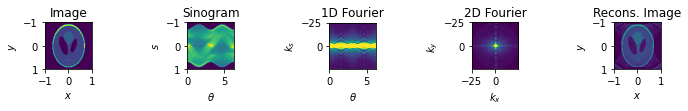

In [72]:
# settings
nx = 100
na = 100
theta = np.linspace(0., 360., na)
sigma = 0

# phantom
u = shepp_logan_phantom()[::4, ::4]

# sinogram
f = radon(u, theta=theta)
f_noisy = f + sigma * np.random.randn(nx,na)


# 1D Fourier and corresponding coordinates
f_hat = fftshift(fft(ifftshift(f,axes=0), axis = 0), axes = 0)
ks = fftshift(fftfreq(nx, 2/nx))

# 2D frequency grid
kx = fftshift(fftfreq(nx, 2/nx))
ky = fftshift(fftfreq(nx, 2/nx))

# interpolate; note that we use a sinogram for theta \in (0,2*pi) because we chose to implement
# the rad2cart function to work only with a positive radius and angles in (0,2*pi). 
# This means that currently only half of the sinogram is used; the other half is redundant due to symmetry.
u_hat = rad2cart(f_hat, -ks, 2*np.pi*np.flip(theta) / 360, kx, ky)

# inverse fft
u_rec = np.real(fftshift(ifft2(ifftshift(u_hat))))


fig, ax = plt.subplots(1,5)

ax[0].imshow(u,vmax=1,extent=(x[0],x[-1],y[-1],y[0]))
ax[0].set_aspect(1)
ax[0].set_title('Image')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')

ax[1].imshow(f,extent=(2*np.pi*theta[0]/360,2*np.pi*theta[-1]/360,x[-1],x[0]))
ax[1].set_aspect(np.pi)
ax[1].set_title('Sinogram')
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel(r'$s$')

ax[2].imshow(np.abs(f_hat),vmax=1e2,extent=(2*np.pi*theta[0]/360,2*np.pi*theta[-1]/360,ks[-1],ks[0]))
ax[2].set_aspect(4*np.pi/nx)
ax[2].set_title('1D Fourier')
ax[2].set_xlabel(r'$\theta$')
ax[2].set_ylabel(r'$k_s$')

ax[3].imshow(np.abs(u_hat),vmax=1e2,extent=(kx[0],kx[-1],ky[-1],ky[0]))
ax[3].set_aspect(1)
ax[3].set_title('2D Fourier')
ax[3].set_xlabel(r'$k_x$')
ax[3].set_ylabel(r'$k_y$')

ax[4].imshow(u_rec,vmax=1, vmin=0,extent=(x[0],x[-1],y[-1],y[0]))
ax[4].set_aspect(1)
ax[4].set_title('Recons. Image')
ax[4].set_xlabel(r'$x$')
ax[4].set_ylabel(r'$y$')

fig.tight_layout()
fig.set_figwidth(10)

plt.savefig("./figures/lec2/fourier_reconstruction.png", 
            dpi=300, transparent = True, bbox_inches = "tight", pad_inches = 0)

> **_NOTE:_** the fourier_reconstruction function uses some of the example code.

In [84]:
def fourier_reconstruction(f, nx):
    # 1D Fourier and corresponding coordinates
    f_hat = fftshift(fft(ifftshift(f, axes=0), axis=0), axes=0)
    ks = fftshift(fftfreq(nx, 2/nx))

    # 2D frequency grid
    kx = fftshift(fftfreq(nx, 2/nx))
    ky = fftshift(fftfreq(nx, 2/nx))

    # interpolate; note that we use a sinogram for theta \in (0,2*pi) because we chose to implement
    # the rad2cart function to work only with a positive radius and angles in (0,2*pi). 
    # This means that currently only half of the sinogram is used; the other half is redundant due to symmetry.
    u_hat = rad2cart(f_hat, -ks, 2*np.pi*np.flip(theta) / 360, kx, ky)

    # inverse fft
    u_rec = np.real(fftshift(ifft2(ifftshift(u_hat))))
    
    return u_rec


# Settings
nx = 400
na = 400
theta = np.linspace(0., 180., na)
sigmas = [.01, .1, 1, 10]
nas = [10, 20, 50, 100]

# Phantom
u = shepp_logan_phantom()

# Sinogram
f = radon(u, theta=theta)


# Table for sigma
print("sigma\terr fr\terr iradon")
for sigma in sigmas:
    # Add noise to sinogram
    f_noisy = f + sigma * np.random.randn(nx, na)
    
    # use fourier reconstruction and calculate error
    u_fr = fourier_reconstruction(f_noisy, nx)
    error_fr = np.linalg.norm(u - u_fr) / np.linalg.norm(u)
    
    # Use iradon and calculate error
    u_fbp = iradon(f_noisy, theta=theta)
    error_fbp = np.linalg.norm(u - u_fbp) / np.linalg.norm(u)
    
    print(f"{sigma}\t{round(error_fr, 4)}\t{round(error_fbp, 4)}")
print("\n")

# Table for na
print("na\terr fr\terr iradon")
for na in nas:
    # Sinogram
    theta = np.linspace(0., 180., na)
    f = radon(u, theta=theta)
    
    # use fourier reconstruction and calculate error
    u_fr = fourier_reconstruction(f, nx)
    error_fr = np.linalg.norm(u - u_fr) / np.linalg.norm(u)
    
    # Use iradon and calculate error
    u_fbp = iradon(f, theta=theta)
    error_fbp = np.linalg.norm(u - u_fbp) / np.linalg.norm(u)
    
    print(f"{na}\t{round(error_fr, 4)}\t{round(error_fbp, 4)}")

sigma	err fr	err iradon
0.01	0.684	0.1257
0.1	0.684	0.1262
1	0.6866	0.1681
10	0.9129	1.1205


na	err fr	err iradon
10	0.7311	1.6401
20	0.6991	0.9141
50	0.6854	0.3731
100	0.6839	0.2024
